                        'N': 'Normal',
                        'VEB': 'Premature ventricular contraction',
                        'SVEB': 'Supraventricular premature beat',
                        'F': 'Fusion of ventricular and normal beat'


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import class_weight, resample
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
ecg_df=pd.read_csv("C:\\Users\\USER\\Desktop\\shi\\MIT-BIH Arrhythmia Database.csv")

Checking for missing values.

In [ ]:
for index, row in ecg_df.iterrows():
    for col in ecg_df.columns:
        if pd.isnull(row[col]):
            print(f"Missing value in row {index}, column {col}")

In [ ]:
#ecg_df=ecg_df.dropna()

Checking for outliers using boxplot.

              record       0_pre-RR      0_post-RR        0_pPeak  \
count  100689.000000  100689.000000  100689.000000  100689.000000   
mean      173.730984     279.400947     278.588207       0.049772   
std        51.673158      81.915453      81.124963       0.168789   
min       100.000000      11.000000       6.000000      -3.094391   
25%       115.000000     230.000000     230.000000      -0.054749   
50%       203.000000     267.000000     266.000000       0.015865   
75%       219.000000     324.000000     322.000000       0.125809   
max       234.000000    2114.000000    2114.000000       3.821118   

             0_tPeak        0_rPeak        0_sPeak        0_qPeak  \
count  100689.000000  100689.000000  100689.000000  100689.000000   
mean        0.372262       1.054485      -0.134376      -0.090466   
std         0.739879       0.617508       1.027590       0.189436   
min        -2.006422      -2.372835      -3.622550      -3.871359   
25%        -0.249060       0.7540

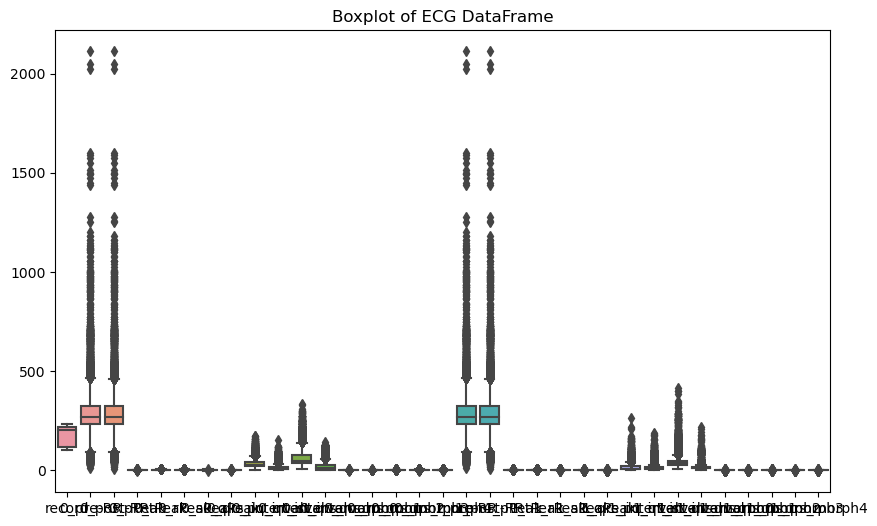

Rows with outliers:
        record type  0_pre-RR  0_post-RR   0_pPeak   0_tPeak   0_rPeak  \
0          101    N        76      313.0  0.074347 -0.160548  1.036401   
1          101    N       313      315.0 -0.052079 -0.264784  0.886597   
8          101    N       313      310.0 -0.061510 -0.257011  1.107787   
19         101    N       325      305.0 -0.085598 -0.305134  0.967730   
29         101    N       295      307.0 -0.085300 -0.315396  0.971516   
...        ...  ...       ...        ...       ...       ...       ...   
100446     234    N       234      248.0 -0.106716 -0.399483  1.268158   
100463     234    N       241      236.0 -0.125662 -0.420807  1.326422   
100535     234    N       232      234.0 -0.102365 -0.424920  1.375149   
100544     234    N       237      238.0 -0.114798 -0.406279  1.353587   
100547     234  VEB       167      313.0  0.084583  0.305422  0.804059   

         0_sPeak   0_qPeak  0_qrs_interval  ...   1_qPeak  1_qrs_interval  \
0      -0.2856

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'ecg_df' is your DataFrame

# Select numerical columns for summary statistics
numerical_cols = ecg_df.select_dtypes(include=['number']).columns
summary_stats = ecg_df[numerical_cols].describe()
print(summary_stats)

# Box plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=ecg_df[numerical_cols])
plt.title("Boxplot of ECG DataFrame")
plt.show()

# Identify and print rows with outliers using the IQR method
Q1 = ecg_df[numerical_cols].quantile(0.25)
Q3 = ecg_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((ecg_df[numerical_cols] < (Q1 - 1.5 * IQR)) | (ecg_df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
outlier_rows = ecg_df[outliers]
print("Rows with outliers:")
print(outlier_rows)


Robust Scaling to minimize outliers effect without the overhead of removing the part of the data or replacing it.

In [5]:
print(ecg_df.info())

numerical_columns = ecg_df.select_dtypes(include=np.number).columns

ecg_df.dropna(subset=numerical_columns, inplace=True)

robust_scaler = RobustScaler()

ecg_df[numerical_columns] = robust_scaler.fit_transform(ecg_df[numerical_columns])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100689 entries, 0 to 100688
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   record          100689 non-null  int64  
 1   type            100689 non-null  object 
 2   0_pre-RR        100689 non-null  int64  
 3   0_post-RR       100689 non-null  float64
 4   0_pPeak         100689 non-null  float64
 5   0_tPeak         100689 non-null  float64
 6   0_rPeak         100689 non-null  float64
 7   0_sPeak         100689 non-null  float64
 8   0_qPeak         100689 non-null  float64
 9   0_qrs_interval  100689 non-null  int64  
 10  0_pq_interval   100689 non-null  int64  
 11  0_qt_interval   100689 non-null  int64  
 12  0_st_interval   100689 non-null  int64  
 13  0_qrs_morph0    100689 non-null  float64
 14  0_qrs_morph1    100689 non-null  float64
 15  0_qrs_morph2    100689 non-null  float64
 16  0_qrs_morph3    100689 non-null  float64
 17  0_qrs_morp

In [6]:
ecg_df['type'].value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64

Dropping the Q column due to low quantity.

In [7]:
mask = ecg_df['type'] =='Q'
ecg_df=ecg_df[~mask]

<Axes: xlabel='type', ylabel='count'>

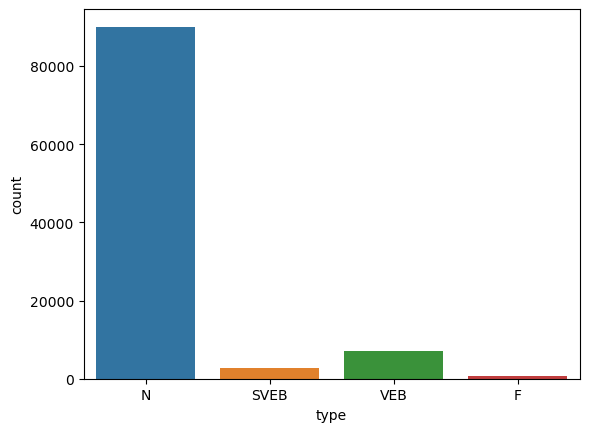

In [8]:
sns.countplot(x='type', data = ecg_df)

Downsampling

In [9]:
import pandas as pd
n_rows = ecg_df[ecg_df['type'] == 'N']

rows_to_keep = int(len(n_rows) * 0.10)

n_rows = n_rows.sample(n=rows_to_keep, random_state=42)

ecg_df = ecg_df[ecg_df['type'] != 'N']

ecg_df = pd.concat([ecg_df, n_rows])


In [10]:
ecg_df['type'].value_counts()

type
N       9008
VEB     7009
SVEB    2779
F        803
Name: count, dtype: int64

In [12]:
print(ecg_df.columns)

Index(['record', 'type', '0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak',
       '0_rPeak', '0_sPeak', '0_qPeak', '0_qrs_interval', '0_pq_interval',
       '0_qt_interval', '0_st_interval', '0_qrs_morph0', '0_qrs_morph1',
       '0_qrs_morph2', '0_qrs_morph3', '0_qrs_morph4', '1_pre-RR', '1_post-RR',
       '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak', '1_qrs_interval',
       '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph0',
       '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4'],
      dtype='object')


Label Encoding for the target variable.

In [13]:
X = ecg_df.drop('type', axis=1)
y = ecg_df['type']
lb= LabelEncoder()
y=lb.fit_transform(y)

In [29]:
X

,record,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
420,-0.980769,-0.776596,1.739130,-0.441555,-0.469011,0.266343,0.119755,-0.243794,-0.20,-0.181818,...,0.228382,-0.266667,-0.500,-1.15,-1.285714,0.228382,0.226947,0.246259,0.297931,0.421107
644,-0.980769,0.702128,1.608696,0.110813,-0.502416,0.284297,0.070290,0.609247,-0.20,-0.181818,...,0.270895,0.600000,-0.625,-0.30,-0.571429,0.270895,0.270943,0.292204,0.331376,0.409789
1537,-0.980769,-0.319149,2.097826,-0.117868,-0.461914,0.373583,0.117490,-0.301272,-0.25,0.090909,...,0.212115,1.733333,-0.375,0.55,-0.857143,0.212115,0.212151,0.263904,0.335933,0.451676
1966,-0.932692,-0.712766,-0.956522,-2.296417,0.099841,-0.064934,-0.547229,-2.806294,2.10,-0.272727,...,0.183384,1.133333,0.375,0.75,0.142857,0.183384,0.204919,0.339528,0.319802,-0.505003
1967,-0.932692,-0.946809,1.793478,4.175346,0.458494,-0.242240,-0.526348,-4.129635,1.55,3.090909,...,-0.717862,-0.133333,1.000,-0.30,-0.857143,-0.717862,-0.677092,-0.489053,-0.353317,-0.217302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55215,-0.961538,0.563830,0.347826,-0.163105,1.119572,0.624236,1.244500,-0.062728,-0.85,0.000000,...,0.307413,0.733333,-0.625,-0.55,-1.571429,0.307413,0.308275,0.325779,0.417098,0.904152
26118,-0.019231,3.021277,1.739130,0.122653,0.453789,-0.511402,0.780216,-0.303540,0.65,1.636364,...,-1.138702,-0.266667,0.250,-0.45,-0.142857,-1.138702,-1.087800,-0.978771,-0.847098,-0.867677
62449,-0.826923,0.936170,0.826087,0.245216,-0.161605,-0.832628,0.010137,-0.030235,-0.25,0.000000,...,0.133812,1.400000,0.000,0.65,-0.285714,0.133812,0.159645,0.382412,1.183900,0.908088
14107,-0.846154,0.414894,0.282609,-0.250405,1.220082,0.804478,1.318189,0.316427,0.30,-0.272727,...,-0.487500,-0.466667,0.375,-0.60,-0.285714,-0.487500,-0.461529,-0.329571,-0.240295,-0.151105


In [30]:
y

array([2, 2, 2, ..., 1, 1, 1])

Upsampling using SMOTE.

In [14]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Before SMOTE:")
print(pd.Series(y).value_counts())
print("After SMOTE:")
print(pd.Series(y_resampled).value_counts())

Before SMOTE:
1    9008
3    7009
2    2779
0     803
Name: count, dtype: int64
After SMOTE:
2    9008
3    9008
0    9008
1    9008
Name: count, dtype: int64


Training the model.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

Model Architecture

In [18]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))

model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

gru_units = 128 
model.add(GRU(gru_units))

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=4, activation='softmax'))


In [19]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Fitting with early stopping method to prevent overfitting.

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50)

Epoch 1/50
442/442 [==============================] - 15s 34ms/step - loss: 0.5597 - accuracy: 0.7881 - val_loss: 0.2885 - val_accuracy: 0.9058
Epoch 2/50
442/442 [==============================] - 14s 32ms/step - loss: 0.2468 - accuracy: 0.9187 - val_loss: 0.1706 - val_accuracy: 0.9448
Epoch 3/50
442/442 [==============================] - 15s 35ms/step - loss: 0.1904 - accuracy: 0.9380 - val_loss: 0.1720 - val_accuracy: 0.9435
Epoch 4/50
442/442 [==============================] - 15s 34ms/step - loss: 0.1529 - accuracy: 0.9497 - val_loss: 0.1429 - val_accuracy: 0.9562
Epoch 5/50
442/442 [==============================] - 15s 34ms/step - loss: 0.1294 - accuracy: 0.9584 - val_loss: 0.1290 - val_accuracy: 0.9609
Epoch 6/50
442/442 [==============================] - 15s 34ms/step - loss: 0.1137 - accuracy: 0.9640 - val_loss: 0.1228 - val_accuracy: 0.9637
Epoch 7/50
442/442 [==============================] - 15s 34ms/step - loss: 0.0977 - accuracy: 0.9677 - val_loss: 0.1160 - val_accuracy:

In [23]:
model.save('ecg_classifier.h5')

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from tensorflow import keras
model = keras.models.load_model('ecg_classifier.h5')

Testing the model on unseen data.

In [25]:
results = model.evaluate(x_test, y_test)
print("Test Loss:", results[0])
print("Test Metrics:", results[1:])

338/338 [==============================] - 3s 8ms/step - loss: 0.1692 - accuracy: 0.9715
Test Loss: 0.16917426884174347
Test Metrics: [0.9715078473091125]


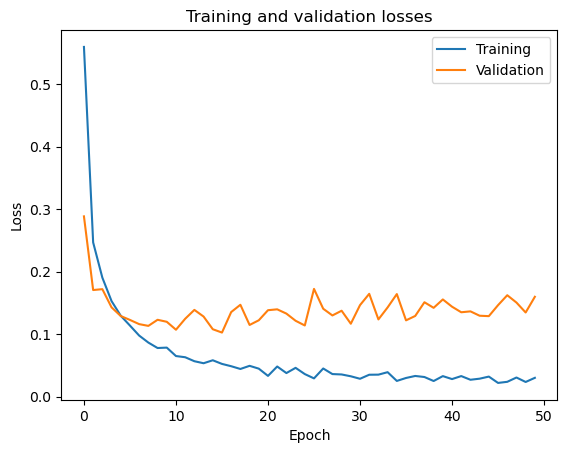

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.legend(['Training', 'Validation'])
plt.title("Training and validation losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Text(0.5, 0, 'epoch')

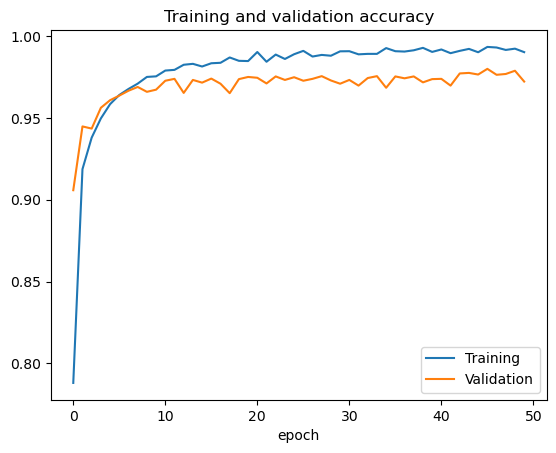

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title("Training and validation accuracy")
plt.xlabel('epoch')